<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_text_classification_by_rnn(English).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Spam Detection

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1.1 Data Load & preprocessing

[다운로드 링크](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv',encoding='latin1')

In [ ]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [ ]:
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# 불필요한 열 삭제
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

# ham과 spam 레이블을 각각 숫자 0과 1로 변경
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])

In [ ]:
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [ ]:
# Null 값 여부 확인
data.isnull().values.any()

False

In [ ]:
# 중복 데이터 여부 확인
data['v2'].nunique(), data['v1'].nunique()

(5169, 2)

* v2열에는 총 5,572개의 샘플이 존재하는데 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미
* v1열에는 0 또는 1 값 밖에 없으므로 2가 출력됨

In [ ]:
# v2 열에서 중복 데이터 제거
data.drop_duplicates(subset=['v2'], inplace=True) # inplace=True : 원본에 바로 적용

In [ ]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


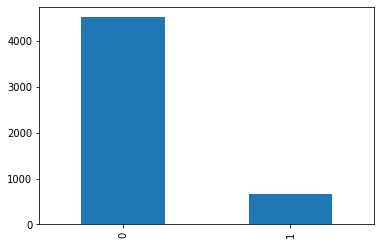

In [ ]:
# 레이블 데이터 분포 확인 (그래프)
data['v1'].value_counts().plot(kind='bar');

In [ ]:
# 레이블 데이터 분포 확인 (수치)
print(data.groupby('v1').size().reset_index(name='count'))

   v1  count
0   0   4516
1   1    653


* 레이블이 대부분 0에 편중되어있음

In [ ]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


## 1.2 Word Tokenization & Integer Encoding

In [ ]:
# 단어 토큰화 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [ ]:
# 인코딩된 정수 인덱스는 빈도수가 높을 수록 낮은 정수값을 부여한 결과
print(sequences[:5])

[[47, 433, 4013, 780, 705, 662, 64, 8, 1202, 94, 121, 434, 1203, 142, 2712, 1204, 68, 57, 4014, 137], [49, 306, 1364, 435, 6, 1767], [53, 537, 8, 20, 4, 1016, 934, 2, 220, 2713, 1365, 706, 2714, 2715, 267, 2716, 70, 2713, 2, 2717, 2, 359, 537, 604, 1205, 82, 436, 185, 707, 437, 4015], [6, 226, 152, 23, 347, 2718, 6, 138, 145, 56, 152], [935, 1, 97, 96, 69, 453, 2, 877, 69, 1768, 198, 105, 438]]


In [ ]:
vocab_size = len(word_to_index) + 1 # 패딩토큰 (0번 인덱스) 고려하여 +1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 8921


In [ ]:
# 단어-인덱스 사전
word_to_index = tokenizer.word_index

In [ ]:
# 빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 2
total_cnt = len(word_to_index)
rare_cnt = 0 # 빈도수가 threshold보다 작은 단어들의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수의 총합
rare_freq = 0 # 빈도수가 threshold보다 작은 단어들의 빈도수의 총합

# tokenizer.word_counts : (단어, 빈도수) 형태로 저장되어있음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4908
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.02242152466368
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.082538108811501


* 등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상의 비율
* 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 6%밖에 되지 않음
* 만약 이러한 분석을 통해 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외하고 싶다면 케라스 토크나이저 선언 시에 단어 집합의 크기를 제한하면 됨
 * ```tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)```
* 이번 실습에서는 별도로 단어 집합의 크기를 제한하진 않음

## 1.3 Data Split

메일의 최대 길이 : 189
메일의 평균 길이 : 15.610370


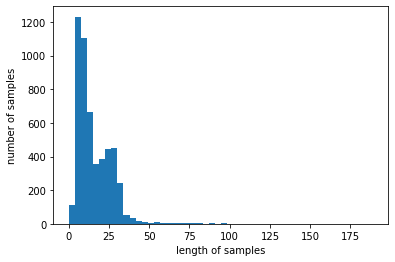

In [ ]:
# 정수 인코딩된 결과 X_data 업데이트
X_data = sequences
print('메일의 최대 길이 : %d' % max(len(l) for l in X_data))
print('메일의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 데이터셋을 max_len으로 패딩
max_len = 189
data = pad_sequences(X_data, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", data.shape)

훈련 데이터의 크기(shape):  (5169, 189)


In [ ]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4135
테스트 데이터의 개수: 1034


In [ ]:
X_test = data[n_of_train:]
y_test = np.array(y_data[n_of_train:])
X_train = data[:n_of_train]
y_train = np.array(y_data[:n_of_train])

## 1.4 Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          285472    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 287,585
Trainable params: 287,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 4s 53ms/step - loss: 0.5670 - acc: 0.7261 - val_loss: 0.4072 - val_acc: 0.8742
Epoch 2/4
52/52 [==============================] - 2s 45ms/step - loss: 0.3217 - acc: 0.8993 - val_loss: 0.2157 - val_acc: 0.9577
Epoch 3/4
52/52 [==============================] - 2s 45ms/step - loss: 0.1112 - acc: 0.9761 - val_loss: 0.2894 - val_acc: 0.8936
Epoch 4/4
52/52 [==============================] - 2s 46ms/step - loss: 0.0567 - acc: 0.9846 - val_loss: 0.0952 - val_acc: 0.9661


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

33/33 [==============================] - 0s 10ms/step - loss: 0.0822 - acc: 0.9729

 테스트 정확도: 0.9729


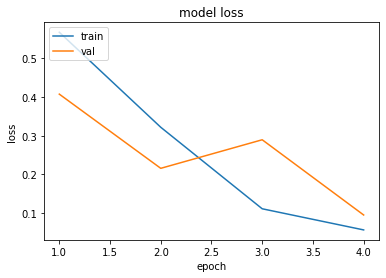

In [ ]:
# 훈련 과정에서 에폭이 진행됨에 따라 변화한 훈련 데이터 및 검증 데이터의 오차 시각화
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2) Reuters News Classification

* 케라스에서 제공하는 뉴스 데이터
* 총 11,258개의 뉴스 기사가 46개의 카테고리로 분류되어있는 데이터

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

## 2.1 Data Load & preprocessing

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


* ```num_words=``` : 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절
 * ```=None``` : 모든 단어 사용

In [ ]:
print('훈련용 뉴스 기사 : {}'.format(len(X_train)))
print('테스트용 뉴스 기사 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [ ]:
print(X_train[0])
print(y_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


* 이미 토큰화 및 정수 인코딩이 진행된 데이터
 * 정수 인덱스는 앞선 __1)__ 에서와 마찬가지로 빈도수가 높을 수록 낮은 인덱스 부여한 결과

뉴스 기사의 최대 길이 :2376
뉴스 기사의 평균 길이 :145.5398574927633


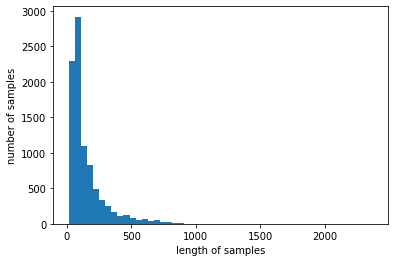

In [ ]:
print('뉴스 기사의 최대 길이 :{}'.format(max(len(l) for l in X_train)))
print('뉴스 기사의 평균 길이 :{}'.format(sum(map(len, X_train))/len(X_train)))

# 뉴스 기사 길이 분포 확인 (시각화)
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


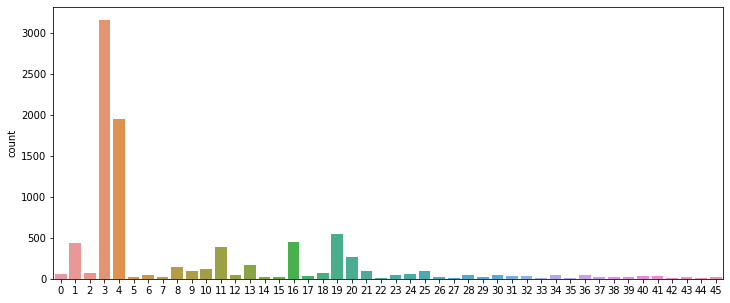

In [ ]:
# 레이블 분포 확인 (시각화)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

In [ ]:
# 레이블 분포 확인 (수치)
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [ ]:
# 단어-인덱스 사전
word_to_index = reuters.get_word_index()

565248/550378 [==============================] - 0s 0us/step


In [ ]:
# 인덱스-단어 사전
index_to_word = {}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token
  
for key, value in word_to_index.items():
    index_to_word[value+3] = key

* index_to_word에서 0은 패딩을 의미하는 토큰인 pad, 1은 문장의 시작을 의미하는 sos, 2는 OOV를 위한 토큰인 unk라는 특별 토큰에 맵핑되어져야 함.
* 따라서 일반 단어들은 인덱스 3부터 시작 (value+3)
* 이는 로이터 뉴스 데이터셋에서 정한 규칙임 

In [ ]:
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 128등 단어 : {}'.format(index_to_word[131]))

빈도수 상위 1번 단어 : the
빈도수 상위 128등 단어 : tax


In [ ]:
# 인덱스-단어 사전으로 인코딩된 데이터 디코딩
print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## 2.2 Padding & One-hot encoding

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
# 등장 빈도 수 상위 1,000번째까지의 단어들만 사용
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

In [ ]:
max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 2.3 Modeling

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
vocab_size = 1000
embedding_dim = 128
hidden_units = 128
num_classes = 46

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         128000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 46)                5934      
Total params: 265,518
Trainable params: 265,518
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - 23s 300ms/step - loss: 2.6099 - acc: 0.3468 - val_loss: 2.3840 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
Epoch 2/30
71/71 [==============================] - 21s 296ms/step - loss: 2.0924 - acc: 0.4758 - val_loss: 1.9809 - val_acc: 0.5111

Epoch 00002: val_acc improved from 0.36198 to 0.51113, saving model to best_model.h5
Epoch 3/30
71/71 [==============================] - 20s 287ms/step - loss: 1.9341 - acc: 0.5019 - val_loss: 1.7974 - val_acc: 0.5530

Epoch 00003: val_acc improved from 0.51113 to 0.55298, saving model to best_model.h5
Epoch 4/30
71/71 [==============================] - 20s 288ms/step - loss: 1.7659 - acc: 0.5475 - val_loss: 1.8049 - val_acc: 0.5445

Epoch 00004: val_acc did not improve from 0.55298
Epoch 5/30
71/71 [==============================] - 21s 291ms/step - loss: 1.6698 - acc: 0.5679 - val_loss: 1.6906 - val_acc: 0.5735

Epoch 00005: val_acc improve

26번째 에포크에서 훈련이 조기 종료되었음

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 2s 25ms/step - loss: 1.2291 - acc: 0.7150

 테스트 정확도: 0.7150


* 케라스의 ```model.fit()```에서 ```validation_data```는 실제 기계가 데이터를 훈련하지는 않고 에포크마다 정확도와 loss를 출력하여 과적합을 판단하기 위한 용도로만 사용되므로, validation_data에서 이미 X_test, y_test를 사용했지만 기계는 아직 이 데이터로 학습한 적이 없는 상태임
* 즉 이 모델은 검증 데이터와 테스트 데이터가 동일하고 따라서 가장 높았던 val_acc가 ```model.evaluate()```로 얻는 테스트 데이터에 대한 정확도와 동일함
* 데이터가 충분하다면, 검증 데이터와 테스트 데이터는 다르게 사용하는 것이 좋음
* ```validation_data``` 대신 ```validation_split=0.2```를 사용하여 검증 데이터와 테스트 데이터에 서로 다른 데이터를 사용하면 다른 결과가 나올 것

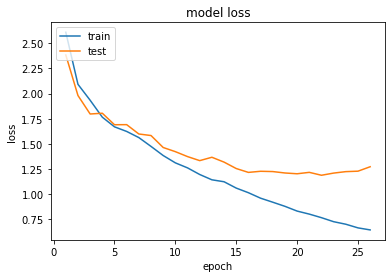

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* 검증 데이터의 손실이 줄어드는 경향이 있지만 뒤로 갈수록 점차 검증 데이터의 손실이 증가하려고 하는 경향이 보임
* 이는 과적합의 신호일 수 있으므로 주의

# 3) IMDB Movie Review Sentiment Analysis

영화 사이트 IMDB 리뷰 데이터
 * 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터
 * 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50대 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하였음 [논문 링크](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)
 * 케라스에서는 해당 IMDB 영화 리뷰 데이터를 ```imdb.load_data()``` 함수를 통해 바로 다운로드 할 수 있도록 지원하고 있음

## 3.1 Data Load & preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb

In [2]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


* 훈련 데이터와 테스트 데이터를 50:50 비율로 구분해서 제공 (데이터의 비율을 조절하는 파라미터는 ```imdb.load_data```에서는 지원하지 않음)
* ```num_classes= ``` 파라미터로 단어 집합 크기 사용 제한 가능

In [3]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [4]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


* 텍스트 데이터는 토큰화와 정수 인코딩 전처리가 끝난 상태

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


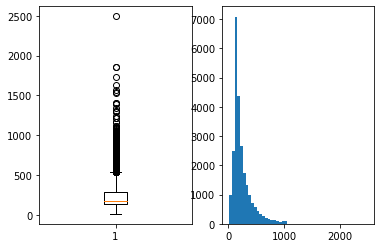

In [5]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [8]:
# 단어-인덱스 사전
word_to_index = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [9]:
# 인덱스-단어 사전
index_to_word = {}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token
  
for key, value in word_to_index.items():
    index_to_word[value+3] = key

* index_to_word에서 0은 패딩을 의미하는 토큰인 pad, 1은 문장의 시작을 의미하는 sos, 2는 OOV를 위한 토큰인 unk라는 특별 토큰에 맵핑되어져야 함.
* 따라서 일반 단어들은 인덱스 3부터 시작 (value+3)
* 이는 IMDB 리뷰 데이터셋에서 정한 규칙임 

In [10]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[3941]))

빈도수 상위 1등 단어 : the
빈도수 상위 3938등 단어 : suited


In [11]:
print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

## 3.2 Padding

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
# 단어 집합 생성 (크기 = vocab_size)
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

In [14]:
# max_len으로 패딩
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 3.3 Modeling

In [15]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [16]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation="sigmoid"))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [20]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
334/334 [==============================] - 265s 788ms/step - loss: 0.4968 - acc: 0.7603 - val_loss: 0.4557 - val_acc: 0.7860

Epoch 00001: val_acc improved from -inf to 0.78600, saving model to GRU_model.h5
Epoch 2/15
334/334 [==============================] - 263s 788ms/step - loss: 0.3182 - acc: 0.8748 - val_loss: 0.2935 - val_acc: 0.8810

Epoch 00002: val_acc improved from 0.78600 to 0.88100, saving model to GRU_model.h5
Epoch 3/15
334/334 [==============================] - 264s 790ms/step - loss: 0.2548 - acc: 0.9042 - val_loss: 0.4711 - val_acc: 0.8474

Epoch 00003: val_acc did not improve from 0.88100
Epoch 4/15
334/334 [==============================] - 264s 792ms/step - loss: 0.1940 - acc: 0.9274 - val_loss: 0.2663 - val_acc: 0.8904

Epoch 00004: val_acc improved from 0.88100 to 0.89040, saving model to GRU_model.h5
Epoch 5/15
334/334 [==============================] - 264s 790ms/step - loss: 0.1544 - acc: 0.9442 - val_loss: 0.2552 - val_acc: 0.9020

Epoch 00005: val

In [21]:
loaded_model = load_model('GRU_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 81s 103ms/step - loss: 0.2722 - acc: 0.8961

 테스트 정확도: 0.8961


## 3.4 Predict

* 임의의 문장에 대해서 리뷰의 긍부정 예측 실험

In [26]:
import re

In [27]:
def sentiment_predict(loaded_model, new_sentence, word_to_index, max_len):
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

  # 정수 인코딩
  encoded = []
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len) # 패딩
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [28]:
# 부정 리뷰 데이터 예시
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

In [29]:
sentiment_predict(loaded_model, test_input, word_to_index, max_len)

96.87% 확률로 부정 리뷰입니다.


In [30]:
# 긍정 리뷰 데이터 예시
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

In [32]:
sentiment_predict(loaded_model, test_input, word_to_index, max_len)

98.51% 확률로 긍정 리뷰입니다.


# 4) Naive Bayes Classifier

* 텍스트 분류를 위해 전통적으로 사용되는 분류기
* 인공 신경망 알고리즘에는 속하지 않지만, 머신 러닝의 주요 알고리즘으로 분류에 있어 준수한 성능을 보여주는 것으로 알려져 있음

## 4.1 Bayes' theorem

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

* $P(A)$ : A가 일어날 확률
* $P(B)$ : B가 일어날 확률
* $P(A|B)$ : B가 일어나고나서 A가 일어날 확률
* $P(B|A)$ : A가 일어나고나서 B가 일어날 확률


## 4.2 Spam Detection by Bayes' theorem

베이즈 정리를 이용하여 스팸 메일 필터를 만든다고 하면

* __P(정상 메일 | 입력 텍스트) = 입력 텍스트가 있을 때 정상 메일일 확률__
* __P(스팸 메일 | 입력 텍스트) = 입력 텍스트가 있을 때 스팸 메일일 확률__

위의 확률을 베이즈 정리를 통해 다시 표현하면 

* __P(정상 메일 | 입력 텍스트) = (P(입력 텍스트 | 정상 메일) × P(정상 메일)) / P(입력 텍스트)__
* __P(스팸 메일 | 입력 텍스트) = (P(입력 텍스트 | 스팸 메일) × P(스팸 메일)) / P(입력 텍스트)__

두 식의 분모가 동일하므로 간소화하여 다시 표현하면

* __P(정상 메일 | 입력 텍스트) = (P(입력 텍스트 | 정상 메일) × P(정상 메일))__
* __P(스팸 메일 | 입력 텍스트) = (P(입력 텍스트 | 스팸 메일) × P(스팸 메일))__

나이브 베이즈 분류기는 입력 텍스트 내부의 단어들을 모두 독립적인 단어로 간주하기 때문에 BoW(Bags of Words)와 같이 단어의 순서를 무시하고 오직 단어의 빈도수만을 고려하므로 (텍스트에 단어가 3개라고 가정했을 때)

* __P(정상 메일 | 입력 텍스트) = P($w_{1}$| 정상 메일) × P($w_{2}$| 정상 메일) × P($w_{3}$| 정상 메일) × P(정상 메일)__
* __P(스팸 메일 | 입력 텍스트) = P($w_{1}$| 스팸 메일) × P($w_{2}$| 스팸 메일) × P($w_{3}$| 스팸 메일) × P(스팸 메일)__

|-  |	메일로부터 토큰화 및 정제 된 단어들|분류     |
|---|:----------------------------------:|:-------:|
|1	|me free lottery	                   |스팸 메일|
|2	|free get free you	                 |스팸 메일|
|3	|you free scholarship	               |정상 메일|
|4	|free to contact me	                 |정상 메일|
|5	|you won award	                     |정상 메일|
|6	|you ticket lottery	                 |스팸 메일|

만약 스팸 메일 데이터가 위와 같을 때, 'you free lottery' 가 정상 메일일 확률과 스팸 메일일 확률을 각각 구하는 식을 작성해보면

* __P(정상 메일 | 입력 텍스트) = P(you | 정상 메일) × P(free | 정상 메일) × P(lottery | 정상 메일) × P(정상 메일)__
* __P(스팸 메일 | 입력 텍스트) = P(you | 스팸 메일) × P(free | 스팸 메일) × P(lottery | 스팸 메일) × P(스팸 메일)__

위 데이터에서 정상메일과 스팸메일은 각각 3개로 계산 상에서 동일한 값이므로 생략할 수 있음

* __P(정상 메일 | 입력 텍스트) = P(you | 정상 메일) × P(free | 정상 메일) × P(lottery | 정상 메일)__
* __P(스팸 메일 | 입력 텍스트) = P(you | 스팸 메일) × P(free | 스팸 메일) × P(lottery | 스팸 메일)__

P(단어| 정상(스팸)메일)은 정상(스팸)메일에 등장한 모든 단어의 빈도 수의 총합을 분모로 하고, 정상(스팸)메일에서 해당 단어가 등장한 총 빈도의 수를 분자로 하여 구할 수 있음

* __P(정상 메일 | 입력 텍스트) = 2/10 × 2/10 × 0/10 = 0__
* __P(스팸 메일 | 입력 텍스트) = 2/10 × 3/10 × 2/10 = 0.012__

결과적으로 P(정상 메일 | 입력 텍스트) < P(스팸 메일 | 입력 텍스트)이므로 입력 텍스트 you free lottery는 스팸 메일로 분류됨

* 그런데 입력 텍스트에 대해서 단 하나의 단어라도 훈련 텍스트에 없었다고 해서 확률 전체가 0이 되는 것은 지나친 일반화임
* 이를 방지하기 위해서 나이브 베이즈 분류기에서는 각 단어에 대한 확률의 분모, 분자에 전부 숫자를 더해서 분자가 0이 되는 것을 방지하는 라플라스 스무딩을 사용하기도 함

## 4.2 Classification of 20 News Group with Naive Bayes Classifier

* 사이킷 런에서는 Twenty Newsgroups이라고 불리는 20개의 다른 주제를 가진 18,846개의 뉴스그룹 데이터를 제공함
* 훈련 데이터(11,314개)와 테스트 데이터(7,532개)로 분류되어있음

### 4.2.1 Data load

In [33]:
from sklearn.datasets import fetch_20newsgroups

In [34]:
# 훈련 데이터 다운로드
newsdata = fetch_20newsgroups(subset='train')
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [35]:
print (len(newsdata.data), len(newsdata.filenames), len(newsdata.target_names), len(newsdata.target))

11314 11314 20 11314


* 훈련용 샘플 : 11314개
* 카테고리 : 20개

In [36]:
# 카테고리 이름 확인
print(newsdata.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [37]:
# 데이터 샘플 확인
print(newsdata.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







### 4.2.2 Classification

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score # 정확도 계산

In [39]:
# 입력한 텍스트를 자동으로 BoW로 만들어 DTM을 만들어주는 CountVectorizer를 사용
dtmvector = CountVectorizer()
X_train_dtm = dtmvector.fit_transform(newsdata.data)
print(X_train_dtm.shape)

(11314, 130107)


* 11,314는 훈련용 샘플의 개수이고 DTM 관점에서는 문서의 수, 130,107은 전체 훈련 데이터에 등장한 단어의 수를 의미

In [40]:
# DTM 행렬을 TF-IDF 행렬로 만들어주는 TfidfTransformer를 사용
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(X_train_dtm)
print(tfidfv.shape)

(11314, 130107)


*  TF-IDF 행렬이 항상 DTM으로 수행했을 때보다 성능이 뛰어나지는 않음

In [41]:
# 나이브 베이즈 모델
mod = MultinomialNB()
mod.fit(tfidfv, newsdata.target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

* ```alpha=1.0``` : 라플라스 스무딩 적용
* ```class_prior=``` : 각 class에 사전 확률 적용
 * If specified the priors are not adjusted according to the data
* ```fit_prior=``` : Whether to learn class prior probabilities or not.
 * If false, a uniform prior will be used.


In [43]:
# 테스트 데이터 다운로드
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)

X_test_dtm = dtmvector.transform(newsdata_test.data) # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(X_test_dtm) # DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test)
print("정확도:", accuracy_score(newsdata_test.target, predicted)) # 예측값과 실제값 비교

정확도: 0.7738980350504514
